<a href="https://colab.research.google.com/github/dutta-arka/Mutual_Transit/blob/main/Code/Kepler_51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gefera

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gefera: filename=gefera-0.1-cp310-cp310-linux_x86_64.whl size=591293 sha256=996b5c06c314882ef2bc2740cdb01e08f644711a7e0a6a9fd37fe039dd890f54
  Stored in directory: /root/.cache/pip/wheels/63/8d/41/bf4921831e168858b005547ed6f3f77c61b80532447d528f5e
Successfully built gefera


In [8]:
!pip install emcee corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.1 MB/s eta 0:00:00


In [15]:
!pip install lightkurve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 23.5 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=9b9a13215207e57bc541b9976c36e8b71876bdd3bf2160b4021cb88e03c921f9
  Stored in directory: /root/.cache/pip/wheels/3c/ea/60/8d1c9fbbc99492a1775b36a5e29c8c1ef309cc5821bd5a219d
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50451 sha256=6238b40bcfcff66fa618c510e77a170a8c4e3d96fec38adbef64032864fb3912
  Stored in directory: /root/.cache/pip/wheels/3e/b8/c5/b553

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gefera as gf
from scipy.optimize import minimize

In [3]:
# load Kepler data for the double transit
t, y = np.loadtxt('k51.txt').T
# arrays need to be fortran-contiguous, a
# characteristic which isn't preserved when
# we transpose the numpy array
t = np.ascontiguousarray(t)
y = np.ascontiguousarray(y)

In [4]:
# initial guess for parameters of Kepler-51 d
a1 = 124.7
t1 = 16.56
e1 = 0.00001
p1 = 130.194
w1 = 90.0 * np.pi / 180
b1 = 0.05
i1 = np.arccos(b1 / a1)
r1 = 0.1

# initial guess for parameters of Kepler-51 b
a2 = 61.5
t2 = 12.41
e2 = 0.00001
p2 = 45.154
w2 = 0.1 * np.pi / 180
om2 = 160 * np.pi / 180
b2 = 0.0
i2 = np.arccos(b2 / a2)
r2 = 0.07

# initial guess for quadratic limb-darkening parameters
u1 = 0.6
u2 = 0.2

# build the system
o1 = gf.orbits.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.orbits.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.systems.ConfocalSystem(o1, o2)

In [5]:
# returns the likelihood and the jacobian of the likelihood
def fun_jac(args):
    sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = args
    o1 = gf.orbits.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
    o2 = gf.orbits.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
    sys = gf.systems.ConfocalSystem(o1, o2)
    ll, dll = sys.loglike(y - 1, t, u1, u2, r1, r2, sigma, grad=True)
    return -ll, -dll

# get the initial light curve for comparison later
x0 = [0.0016, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2]
o1 = gf.orbits.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.orbits.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.systems.ConfocalSystem(o1, o2)
lc_start = sys.lightcurve(t, u1, u2, r1, r2, grad=False)

CPU times: user 339 ms, sys: 4.1 ms, total: 343 ms
Wall time: 482 ms


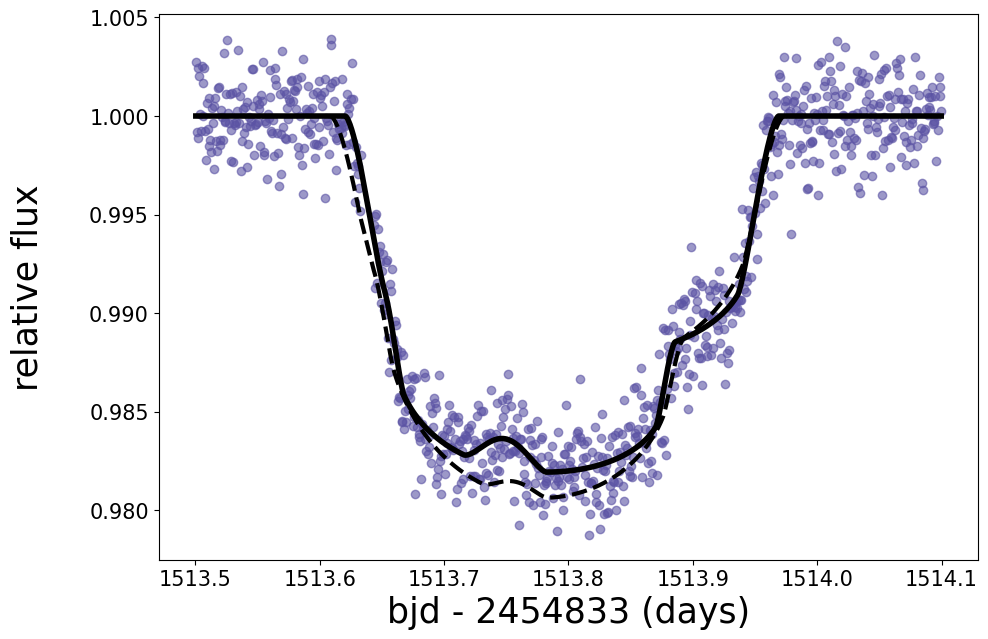

In [6]:
# do the minimization
%time res = minimize(fun_jac, x0, jac=True, method='TNC')

# get the minimized lightcurve
sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = res.x
o1 = gf.orbits.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.orbits.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.systems.ConfocalSystem(o1, o2)
lc = sys.lightcurve(t, u1, u2, r1, r2, grad=False)

# plot everything
plt.figure(figsize=(10, 7))
plt.plot(t, y, 'o', color=plt.cm.Spectral(0.99), alpha=0.6)
plt.plot(t, lc + 1, color='k', linewidth=4)
plt.plot(t, lc_start + 1, '--', color='k', linewidth=3)

plt.ylabel('relative flux\n', fontsize=25)
plt.xlabel('bjd - 2454833 (days)', fontsize=25)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.tight_layout()
plt.subplots_adjust(top=0.9)

100%|██████████| 1000/1000 [01:04<00:00, 15.54it/s]


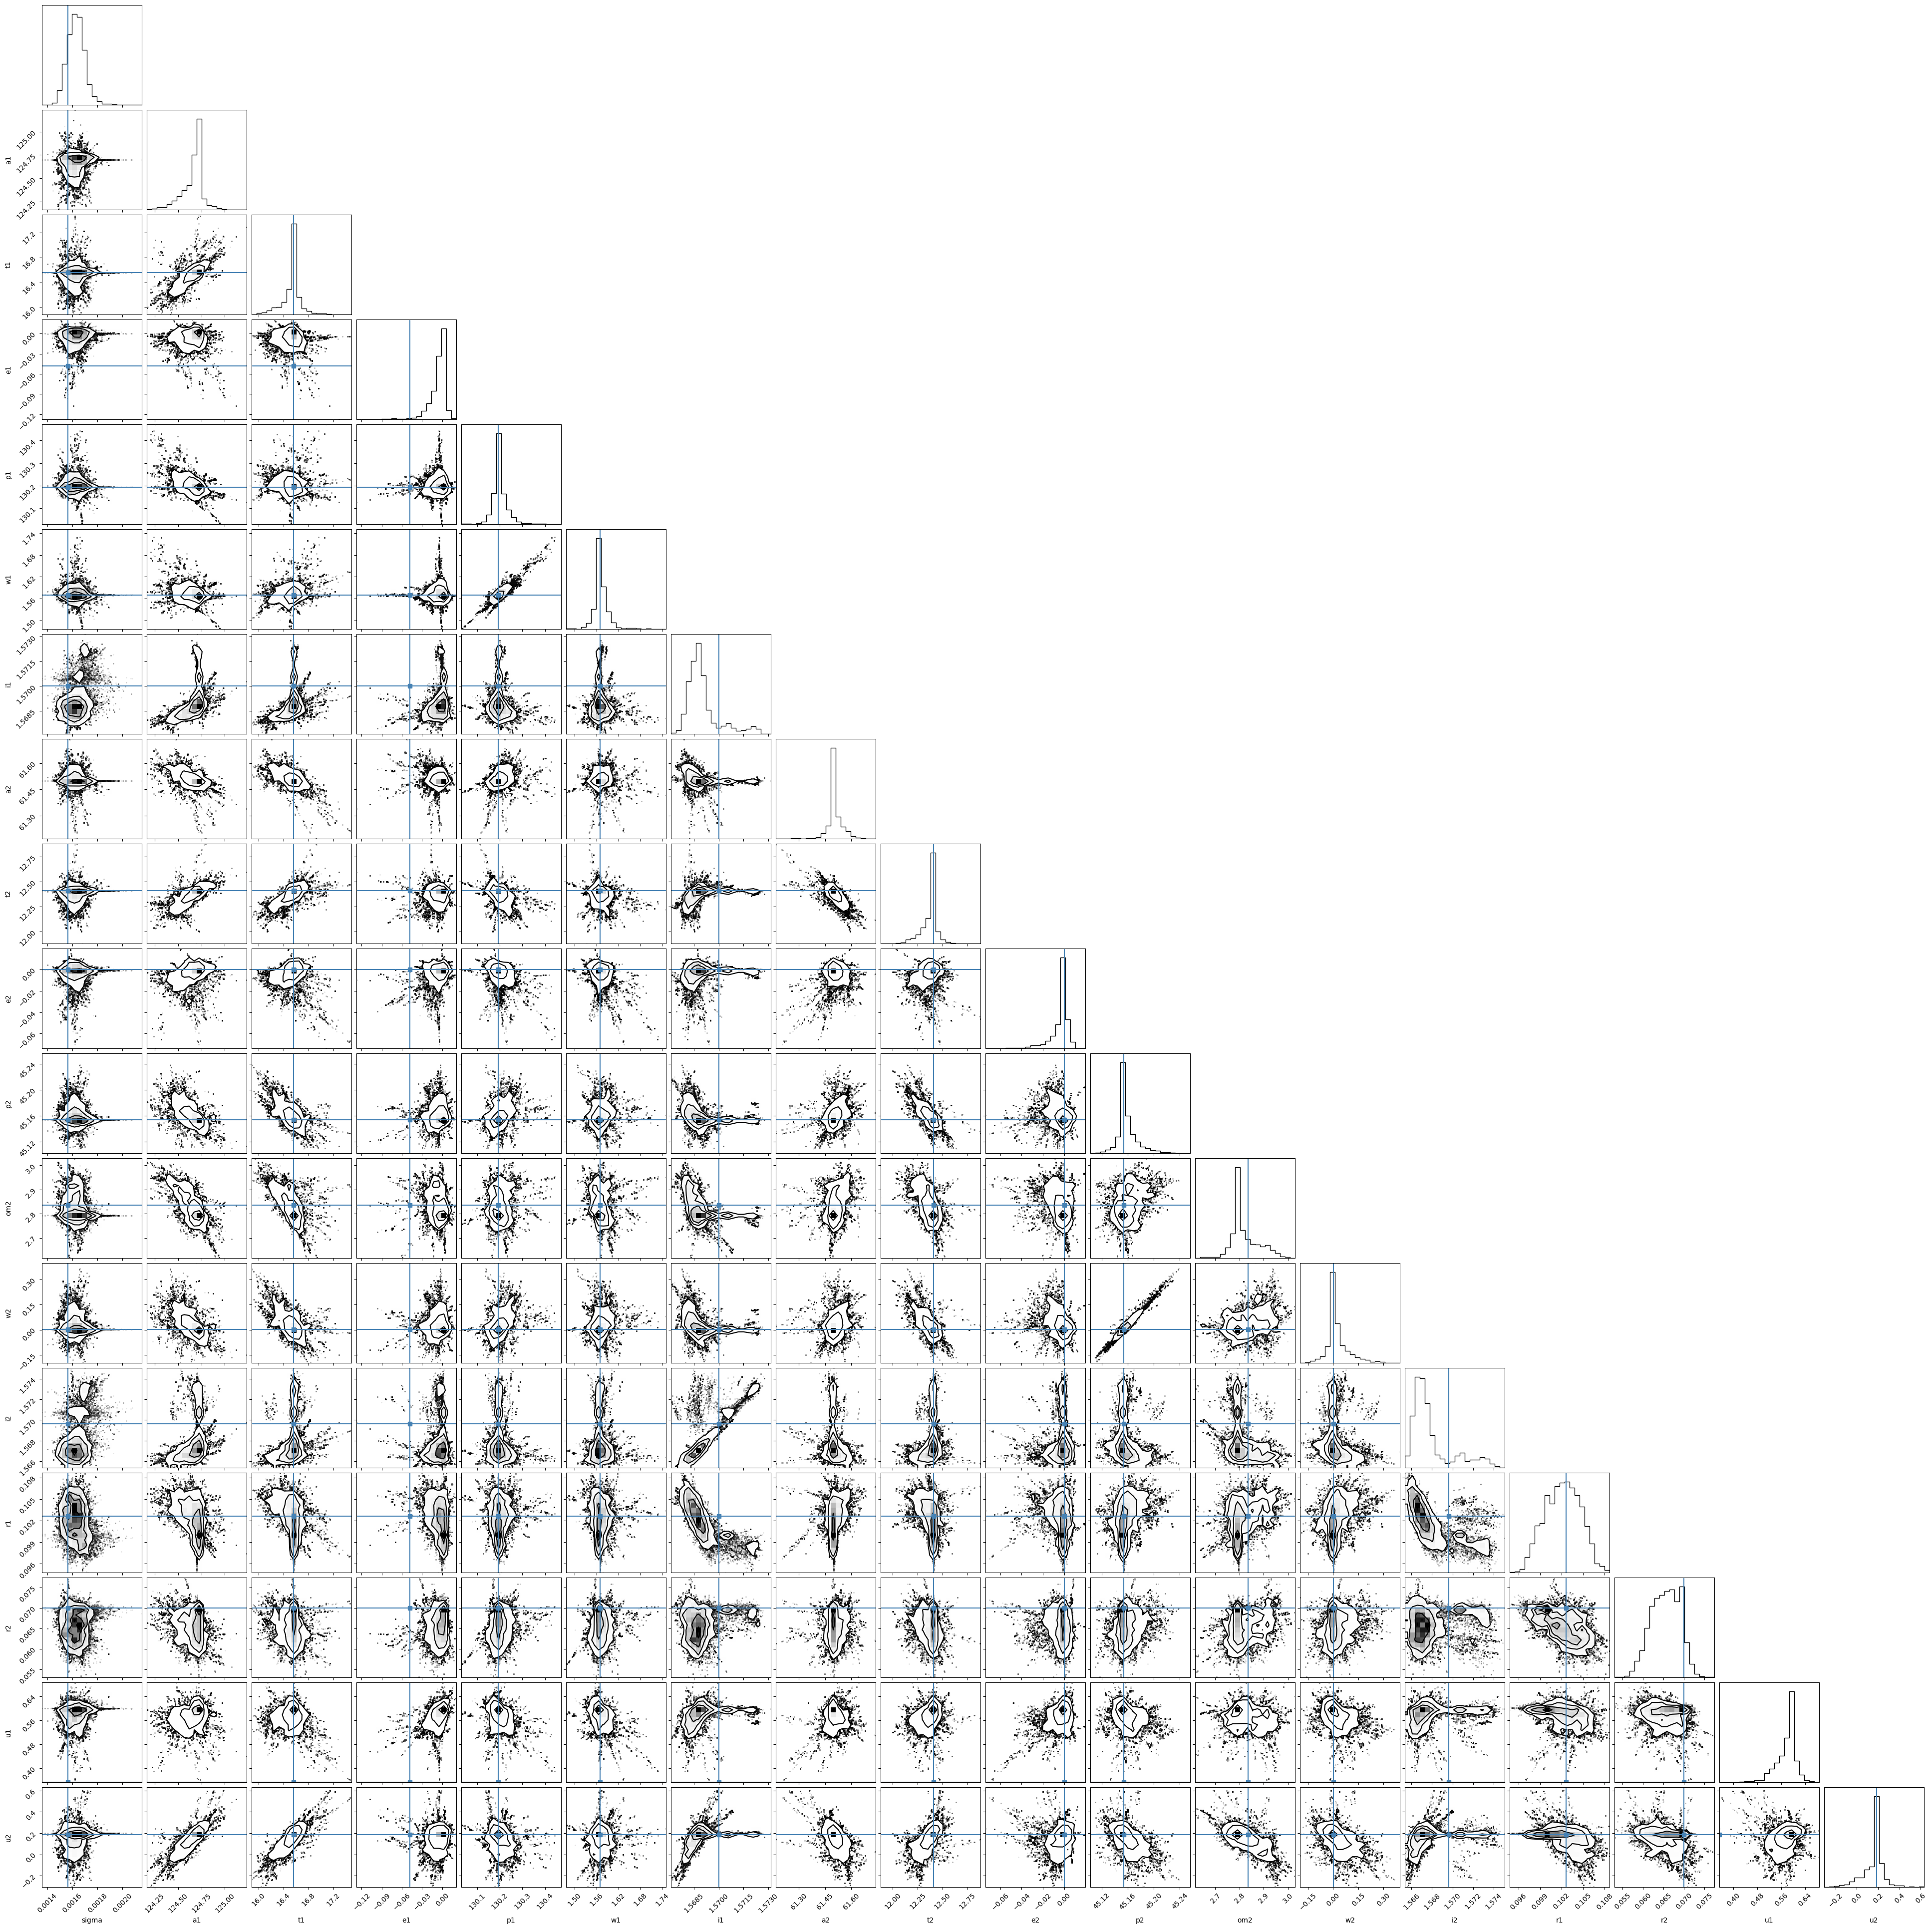

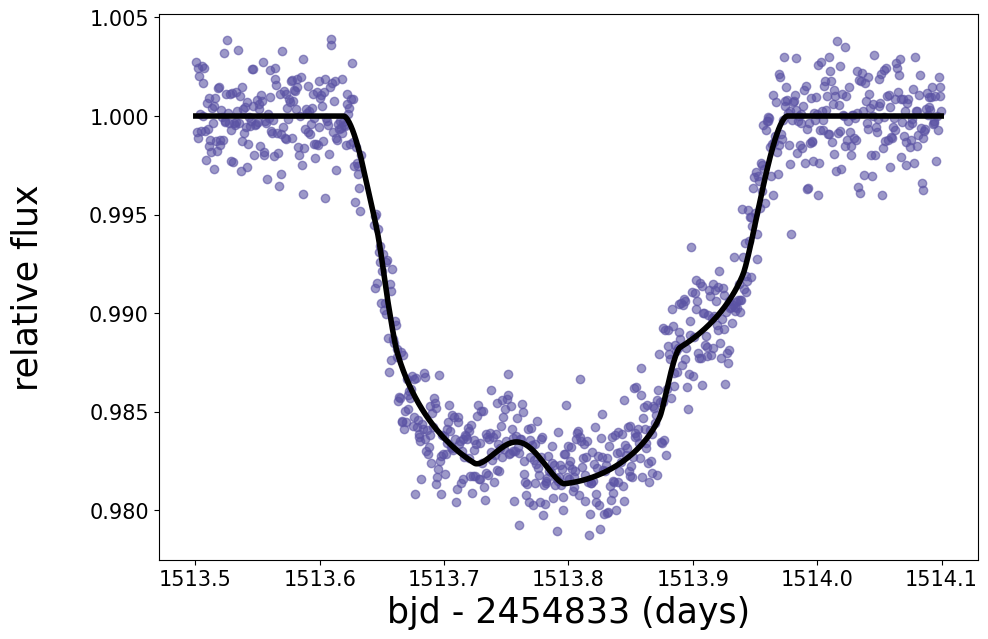

In [9]:
import numpy as np
import emcee
import corner

# Define the log likelihood function
def log_likelihood(args):
    # Unpack the parameters
    sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = args

    # Define the orbits and system
    o1 = gf.orbits.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
    o2 = gf.orbits.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
    sys = gf.systems.ConfocalSystem(o1, o2)

    # Compute the log likelihood
    return sys.loglike(y - 1, t, u1, u2, r1, r2, sigma)

# Define the log prior function
def log_prior(args):
    # Unpack the parameters
    sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = args

    # Define prior ranges for parameters
    sigma_range = (0, 0.01)  # Example range for sigma
    a1_range = (100, 150)  # Example range for a1
    # Define ranges for other parameters as needed

    # Check if parameters are within the prior ranges
    if not all([sigma_range[0] < sigma < sigma_range[1], a1_range[0] < a1 < a1_range[1]]):
        return -np.inf  # Return negative infinity for parameters outside prior ranges

    # Add prior checks for other parameters as needed

    return 0  # Return zero for parameters within prior ranges

# Define the log posterior function
def log_posterior(args):
    lp = log_prior(args)
    if not np.isfinite(lp):
        return -np.inf  # Return negative infinity if parameters are outside prior ranges
    return lp + log_likelihood(args)  # Compute log posterior as sum of log prior and log likelihood

# Set up the MCMC sampler with more walkers
ndim = len(x0)  # Dimensionality of parameter space
nwalkers = 4 * ndim  # Number of walkers increased
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# Run the sampler
initial_pos = [x0 + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]  # Initialize walkers near initial guess
sampler.run_mcmc(initial_pos, 1000, progress=True)  # Run MCMC for 1000 steps

# Plot the posterior using corner
samples = sampler.get_chain(flat=True)
labels=['sigma', 'a1', 't1', 'e1', 'p1', 'w1', 'i1', 'a2', 't2', 'e2', 'p2', 'om2', 'w2', 'i2', 'r1', 'r2', 'u1', 'u2']
corner.corner(samples, labels=labels, truths=res.x)  # Use the truths argument to mark the refined values

# Extract the refined values from the posterior
refined_values = np.median(samples, axis=0)  # Median of the posterior distribution

# Extract the refined values of the parameters
sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = refined_values

# Plot the refined light curve
o1 = gf.orbits.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.orbits.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.systems.ConfocalSystem(o1, o2)
lc = sys.lightcurve(t, u1, u2, r1, r2, grad=False)

plt.figure(figsize=(10, 7))
plt.plot(t, y, 'o', color=plt.cm.Spectral(0.99), alpha=0.6)
plt.plot(t, lc + 1, color='k', linewidth=4)

plt.ylabel('relative flux\n', fontsize=25)
plt.xlabel('bjd - 2454833 (days)', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

In [10]:
%%capture
from IPython.display import HTML
fig = plt.figure(figsize=(10, 10))

ani = gf.animate.animate(
    sys,
    fig,
    t[::10],
    r1,
    r2,
    ld_params=(u1, u2)
)

In [11]:
HTML(ani.to_html5_video())

In [12]:
depth1 = sys.lightcurve(t, u1, u2, r1, 0, grad=False)  # Transit depth for planet 1
depth2 = sys.lightcurve(t, u1, u2, 0, r2, grad=False)  # Transit depth for planet 2

In [13]:
def find_zeros(arr, index):
    left_indices = []
    right_indices = []

    # Search for the first zero on the left side
    for i in range(index, -1, -1):
        if arr[i] == 0:
            left_indices.append(i)
            break

    # Search for the first zero on the right side
    for i in range(index, len(arr)):
        if arr[i] == 0:
            right_indices.append(i)
            break

    return left_indices, right_indices

# Test the function
arr = depth1 + depth2
index = np.argmin(arr)

left_indices, right_indices = find_zeros(arr, index)

# Print the left and right indices for each minimum value
for left, right in zip(left_indices, right_indices):
    print("Left index:", left)
    print("Right index:", right)
    print(arr[left:right + 1])

    num = int(0.2 * len(arr[left:right + 1]))
    print("Number of elements to select:", num)

    lc = arr[(left - num):(right + 1 + num)]
    print("Selected portion of array:", lc)
    print()

Left index: 174
Right index: 684
[ 0.00000000e+00 -3.26090269e-06 -2.61034773e-05 -6.31580608e-05
 -1.11953479e-04 -1.71199500e-04 -2.40049564e-04 -3.17869622e-04
 -4.04111252e-04 -4.98351727e-04 -6.00168688e-04 -7.09235536e-04
 -8.25157203e-04 -9.47729338e-04 -1.07659309e-03 -1.21150937e-03
 -1.35217186e-03 -1.49834116e-03 -1.64978725e-03 -1.80621755e-03
 -1.96738525e-03 -2.13311992e-03 -4.99309276e-03 -5.19660270e-03
 -5.40006815e-03 -5.60303601e-03 -5.80640093e-03 -6.03480025e-03
 -6.28349164e-03 -6.54725864e-03 -6.82310081e-03 -7.10873391e-03
 -7.40220796e-03 -7.70156153e-03 -8.00469451e-03 -8.30951659e-03
 -8.61341342e-03 -8.91316516e-03 -9.20328056e-03 -9.47328822e-03
 -9.73849912e-03 -1.00010517e-02 -1.02606077e-02 -1.05162935e-02
 -1.07670707e-02 -1.10114199e-02 -1.12474969e-02 -1.14726959e-02
 -1.16831425e-02 -1.18692884e-02 -1.20239420e-02 -1.21693786e-02
 -1.23078301e-02 -1.24404652e-02 -1.25680610e-02 -1.26911365e-02
 -1.28101269e-02 -1.29254336e-02 -1.30372960e-02 -1.31459

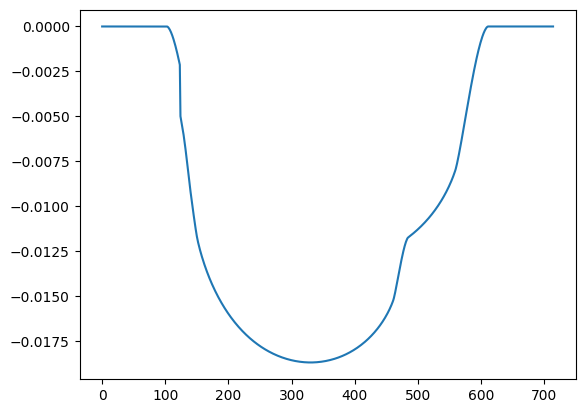

In [14]:
plt.plot(lc)

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

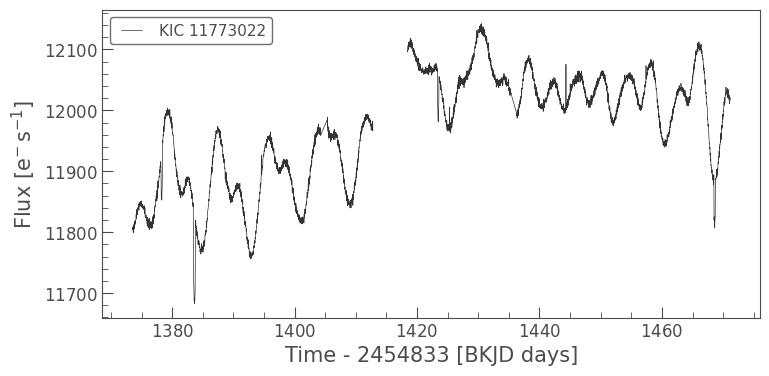

In [16]:
from lightkurve import search_targetpixelfile

# First we open a Target Pixel File from MAST, this one is already cached from our previous tutorial!
tpf = search_targetpixelfile('Kepler-51', author="Kepler", cadence="long", quarter=15).download()

# Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

lc.plot()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

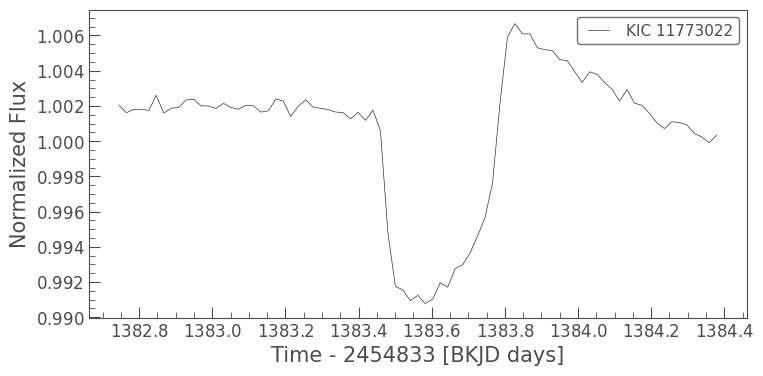

In [21]:
flat_lc = lc.flatten(window_length=401)
flat_lc[450:530].plot()